In [1]:
# import numpy as np
import autograd.numpy as np
from autograd import grad
import matplotlib 
import matplotlib as mpl

import csper.periodograms as cs 
from exotk.utils.misc import fold

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
matplotlib.rcParams['axes.facecolor']='white'
matplotlib.rcParams['savefig.facecolor']='white'

colours = mpl.rcParams['axes.color_cycle'] 


Populating the interactive namespace from numpy and matplotlib


/Users/benjaminpope/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['np']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/Users/benjaminpope/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


## Basis Pursuit for Spectrum Estimation

Following Chen & Donoho, "APPLICATION OF BASIS PURSUIT IN SPECTRUM ESTIMATION"

https://pdfs.semanticscholar.org/1bb0/74529d4a5d56cc9d05befcc3dcde957420fb.pdf

We want to be able to infer the power spectrum of a signal which is sparse in the Fourier domain, given potentially sparse, irregularly sampled time series. Using an L1 norm algorithm, we can fit simultaneously a sum of sines, cosines, polynomial terms, and Dirac delta functions to represent outliers, and get a pretty decent fit.

In [29]:
time = np.linspace(0,100,1000)
y = np.zeros_like(time)

inputs = [1.,2., 2.5, 4.3] # to do it manually
amps = [1., 0.2, 3., 0.5]

inputs = np.random.rand(5)*5. # to randomly generate some frequencies
amps = np.random.rand(5)+0.5

for j, f in enumerate(inputs): 
    y += amps[j]*np.sin(f*time)
    
snr = 1000. # dial it down to add more white noise

y += (y.max()/snr) * np.random.randn(len(y))

y = (y-y.min())/(y.max()-y.min())

args = np.sort(np.random.choice(len(time),size=100,replace=False)) # only choose 100 points, at random

tt, yy = time[args], y[args]


In [30]:
np.unique(args).shape

(100,)

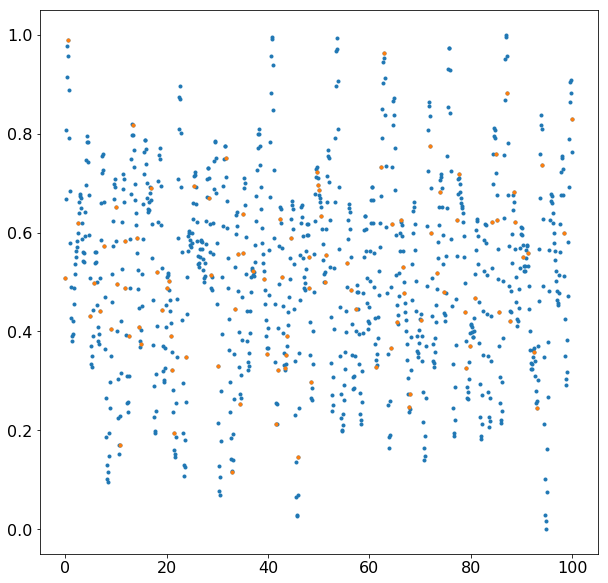

In [31]:
plt.plot(time,y,'.')
plt.plot(tt,yy,'.')

### For basis pursuit: 
https://github.com/drrelyea/SPGL1_python_port 

### minimize ||x||_1 subject to Ax = b




In [32]:
%%time
output = cs.basis_pursuit(tt,yy,nfreqs=500,fmin=0.1,fmax=10,polyorder=2)

CPU times: user 389 ms, sys: 15.6 ms, total: 404 ms
Wall time: 395 ms


In [33]:
power = (output['sines']**2 + output['cosines']**2)
freqs = output['freqs']
diracs = output['diracs']
polys = output['polys']
residuals = output['resid']
print output['polys']

[0.00000000e+00 2.01568491e-08 5.07232618e-01]


In [34]:
pf = np.poly1d(polys)

Text(0.5,1.01,u'L1 Periodograms Nail It')

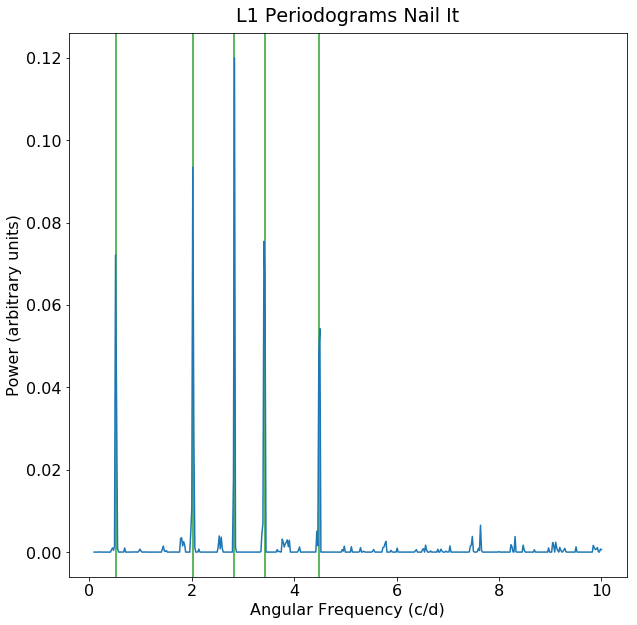

In [37]:
# plt.plot(freqs,sines)
# plt.plot(freqs,cosines)
for f in inputs:
    plt.axvline(f,color=colours[2])
    
plt.plot(freqs,np.sqrt(power))
plt.xlabel("Angular Frequency (c/d)")
plt.ylabel("Power (arbitrary units)")
plt.title("L1 Periodograms Nail It", y=1.01)

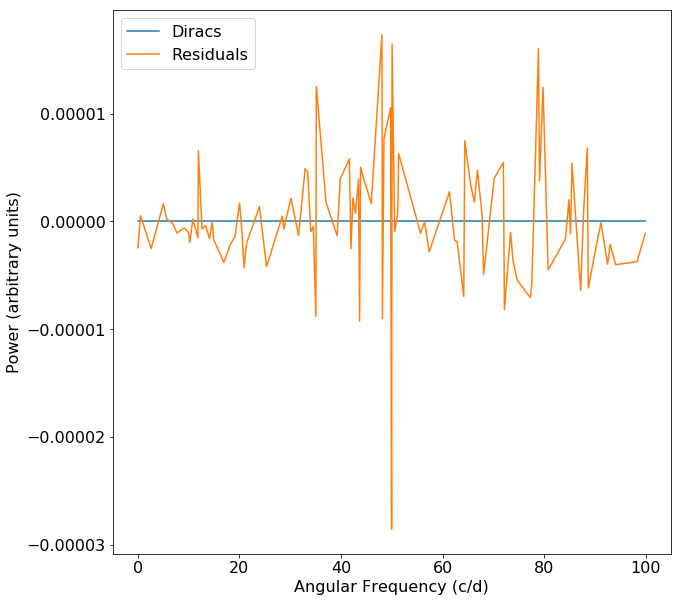

In [38]:
plt.plot(tt,diracs,label="Diracs")
plt.plot(tt,residuals,label="Residuals")
plt.xlabel("Angular Frequency (c/d)")
plt.ylabel("Power (arbitrary units)")
plt.legend()

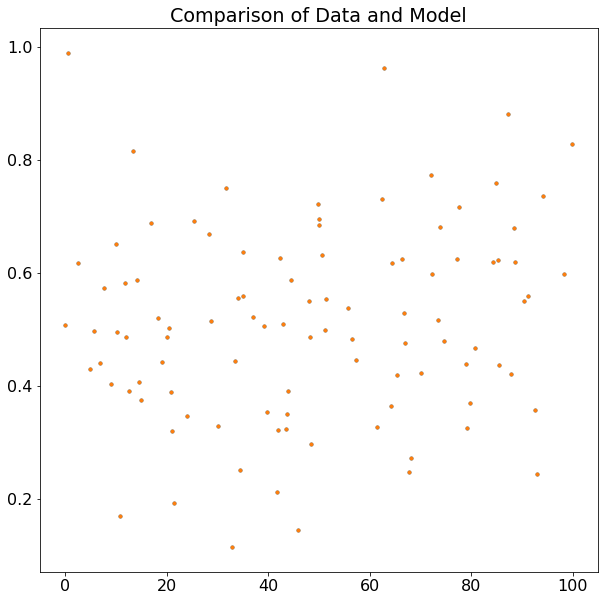

In [39]:
plt.title("Comparison of Data and Model")
plt.plot(tt,yy,'.')
plt.plot(tt,output['model'],'.')

### How does this perform as you reduce the number of samples?

In [11]:
%%time
recovered = []
sizes = [10,20,30,40,50,100,200,500,1000]

ys = np.sin(time)

for sz in sizes:
    args = np.sort(np.random.choice(len(time),size=sz,replace=False))

    tt, yy = time[args], ys[args]
    output = cs.basis_pursuit(tt,yy)
    power = (output['sines']**2 + output['cosines']**2)
    freqs = output['freqs']
    
    recovered.append(freqs[np.argmax(power)])

No handlers could be found for logger "spgl1.spgl1"


CPU times: user 36.4 s, sys: 542 ms, total: 37 s
Wall time: 18.9 s


Text(0.5,1,u"You don't need many samples and you can recover the frequency to ~0.1%")

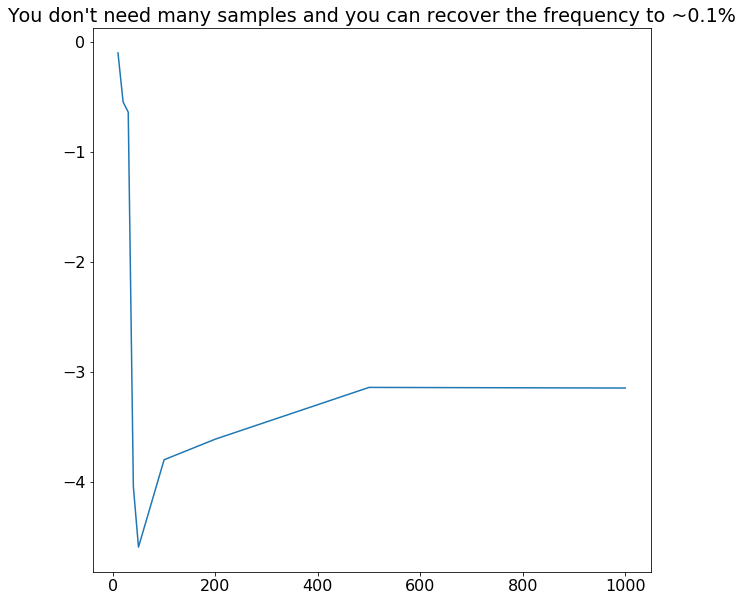

In [41]:
plt.plot(sizes,np.log10(np.abs(1.-np.array(recovered))))
plt.title("You don't need many samples and you can recover the frequency to ~0.1%")

In [13]:
# recovered

### How does this perform on real data?

In [14]:
ls /Users/benjaminpope/code/Aldebaran/hipp/

alpha-Aql-hipp.txt    alpha-Ori-hipp.txt    beta-Oph-hipp.txt
alpha-Ari-hipp.txt    alpha-Per-hipp.txt    beta-UMi-hipp.txt
alpha-Aur-hipp.txt    alpha-Tau-hipp.txt    epsilon-Car-hipp.txt
alpha-Boo-hipp.txt    alpha-TrA-hipp.txt    epsilon-Tau-hipp.txt
alpha-CMa-hipp.txt    alpha-UMa-hipp.txt    gamma-Dra-hipp.txt
alpha-Car-hipp.txt    alpha-UMi-hipp.txt    gamma-Per-hipp.txt
alpha-Cas-hipp.txt    alpha2-Cen-hipp.txt   pi-Her-hipp.txt
alpha-Hya-hipp.txt    beta-Cet-hipp.txt     theta-Cen-hipp.txt
alpha-Lyr-hipp.txt    beta-Gem-hipp.txt


In [15]:
fname = '/Users/benjaminpope/code/Aldebaran/hipp/beta-Cet-hipp.txt'

In [16]:
def read_hipp(fname):
    with open(fname) as f:
        lines = f.readlines()[27:]

    time, flux, err = 1.*np.zeros(len(lines)), 1.*np.zeros(len(lines)),1.*np.zeros(len(lines))


    for j,line in enumerate(lines):
        if line == '\n':
            break
        l = line.split("|")
        time[j] = l[0]
        flux[j] = l[1]
        err[j] = l[2]

    time = time[:j]
    flux = flux[:j]
    err = err[:j]
    
    return time, flux,err

In [17]:
time, flux, err = read_hipp(fname)
time -= time.min()

<Container object of 3 artists>

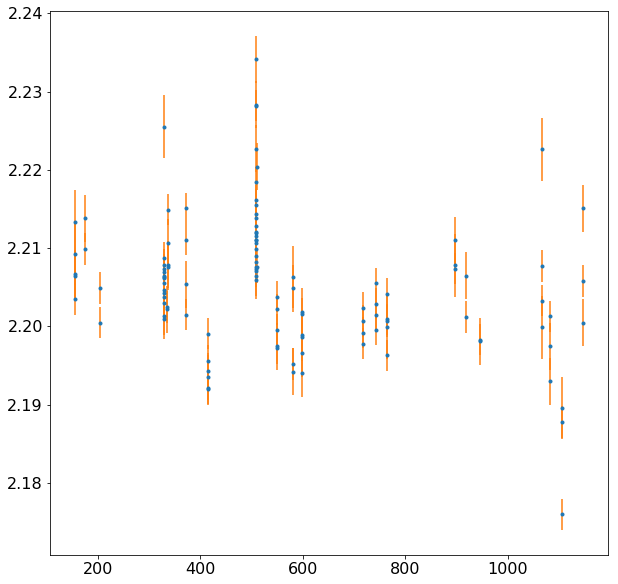

In [18]:
m = [err<0.005]

plt.plot(time[m],flux[m],'.')
plt.errorbar(time[m],flux[m],yerr=err[m],linestyle="none")
# plt.xlim(180,181)

In [19]:
# period = 3.969
# period = 8.107
m = [err<0.005]
folded = fold(time[m],period)
plt.plot(folded,flux[m],'.')
plt.errorbar(folded,flux[m],yerr=err[m],linestyle="none")


NameError: name 'period' is not defined

In [ ]:
%%time
fake = np.sin(2*np.pi/3.969 * time)
polaris = cs.basis_pursuit(time[m],flux[m],nfreqs=5000,polyorder=4)

In [ ]:
power = (polaris['sines']**2 + polaris['cosines']**2)

plt.plot(polaris['freqs'],power)
plt.axvline(2*np.pi/3.969,color=colours[2])

In [ ]:
period = 2*np.pi/polaris['freqs'][np.argmax(power)]
print period